In [2]:
from fastai.imports import *
from fastai.vision import *
import tifffile as tiff
from skimage.external import tifffile as sktif
from joblib import Parallel, delayed
import torch.functional as F

import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

In [3]:
data_dir = Path("/media/wwymak/Storage/urban-3D-satellite")

In [4]:
train_dir = data_dir / "training"
files = train_dir.ls()
print(len(files))

1218


In [19]:
files[0]

PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/TAM_Tile_132_GTC.tif')

In [20]:
set([str(f.name).split("_")[-1] for f in files])

{'DSM.tif', 'DTM.tif', 'GTC.tif', 'GTI.tif', 'GTL.tif', 'RGB.tif'}

In [5]:
rgb_files = [f for f in files if str(f.name).endswith('_RGB.tif')]
len(rgb_files)

174

In [6]:
ground_truth_class_level_files = [f for f in files if str(f.name).endswith('GTL.tif') and not str(f.name).endswith('pytorch_GTL.tif')]
ground_truth_inst_level_files = [f for f in files if str(f.name).endswith('GTI.tif')]

In [7]:
ground_truth_class_level_files[:5]

[PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_007_GTL.tif'),
 PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_031_GTL.tif'),
 PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_032_GTL.tif'),
 PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/TAM_Tile_017_GTL.tif'),
 PosixPath('/media/wwymak/Storage/urban-3D-satellite/training/TAM_Tile_128_GTL.tif')]

In [6]:
def convert_gtl(fpath, outpath):    
    a = sktif.imread(str(fpath))
    b = a.copy()
    
    np.place(b, b<6,0) #void
    np.place(b, b>=6,1) #building
    assert b.max()<=1, b.max()
    
    sktif.imsave(str(outpath),b)


In [51]:
inpaths = ground_truth_class_level_files
outpaths = [str(f).replace("GTL", "pytorch_GTL") for f in ground_truth_class_level_files]
outpaths[:5]

['/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_007_pytorch_GTL.tif',
 '/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_031_pytorch_GTL.tif',
 '/media/wwymak/Storage/urban-3D-satellite/training/JAX_Tile_032_pytorch_GTL.tif',
 '/media/wwymak/Storage/urban-3D-satellite/training/TAM_Tile_017_pytorch_GTL.tif',
 '/media/wwymak/Storage/urban-3D-satellite/training/TAM_Tile_128_pytorch_GTL.tif']

In [62]:
%time  [convert_gtl(inpath, outpath) for inpath, outpath in zip(inpaths, outpaths)];

CPU times: user 1.89 s, sys: 394 ms, total: 2.29 s
Wall time: 4.06 s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [68]:
len(inpaths)

174

In [9]:
def scale_percentile(matrix):
    # scale tiff files read by tifffile to an rgb format readable by e.g. mpl for display
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

def plot_mask_img(img_id, road_mask_width=4):
#     mask_fname = data_dir / "training" / f"{img_id}_GTL.tif"
    mask_fname = data_dir / "training" / f"{img_id}_pytorch_GTL.tif"
    img_fname = data_dir / "training" / f"{img_id}_RGB.tif"
    img_mask= tiff.imread(str(mask_fname))
    img_rgb= tiff.imread(str(img_fname))
    f = plt.figure(figsize=(10,6))
    plt.subplot(121)
    tiff.imshow(img_rgb, figure=f, subplot=121);
    print(img_rgb.shape)
    plt.subplot(122)
    tiff.imshow(img_mask,figure=f, subplot=122, vmin=0, vmax=1);

In [11]:
img_ids = [f.name.replace("_RGB.tif", "") for f in rgb_files]

/home/wwymak/anaconda3/envs/solaris/lib/python3.6/site-packages/tifffile/tifffile.py:11725: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  subplot = pyplot.subplot(subplot)


(2048, 2048, 3)


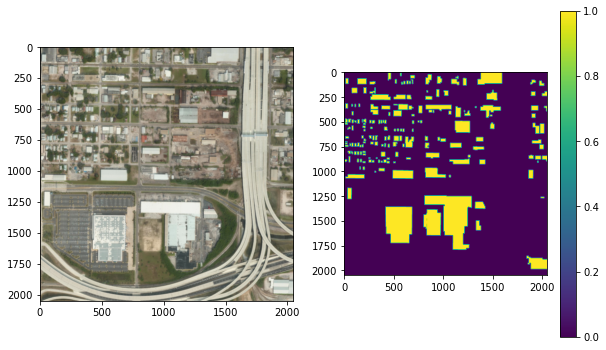

In [65]:
plot_mask_img(img_ids[90])

In [8]:
cropped_dir =  data_dir / "cropped_training"
cropped_dir.mkdir(exist_ok=True)

cropped_val_dir =  data_dir / "cropped_validation"
cropped_val_dir.mkdir(exist_ok=True)

In [27]:
def get_crop_coords(img, new_h, new_w, n):
    h, w = img.shape[:2]
    if w == new_w and h == new_h:
        return 0, 0, h, w

    i_list = [random.randint(0, h - new_h) for i in range(n)]
    j_list = [random.randint(0, w - new_w) for i in range(n)]
    return i_list, j_list

def generate_cropped_img_mask(img_id, n_crops_per_img = 15, new_h=256, new_w=256, dataset_type="train"):
    if dataset_type=="train":
        cropped_dir =  data_dir / "cropped_training"
    else:
        cropped_dir =  data_dir / "cropped_validation"
    instance_mask_fname = data_dir / "training" / f"{img_id}_GTI.tif"
    mask_fname = data_dir / "training" / f"{img_id}_pytorch_GTL.tif"
    img_fname = data_dir / "training" / f"{img_id}_RGB.tif"
    
    img_inst_mask = sktif.imread(str(instance_mask_fname))
    img_mask= sktif.imread(str(mask_fname))
    img_rgb= sktif.imread(str(img_fname))
    
    y_list, x_list = get_crop_coords(img_rgb, new_h, new_w, n_crops_per_img)
    
    instance_masks =  [img_inst_mask[i: i+new_h, j: j+new_w] for (i, j )in zip(y_list, x_list)]
    masks = [img_mask[i: i+new_h, j: j+new_w] for (i, j )in zip(y_list, x_list)]
    rgbs = [img_rgb[i: i+new_h, j: j+new_w] for (i, j )in zip(y_list, x_list)]
    
    fnames_instance_masks = [cropped_dir / f"{img_id}_{idx}_GTI.tif" for idx in range( len(rgbs))]
    fnames_masks = [cropped_dir / f"{img_id}_{idx}_pytorch_GTL.tif" for idx in range( len(rgbs))]
    fnames_imgs = [cropped_dir / f"{img_id}_{idx}_RGB.tif" for idx in range(len(rgbs))]
    
    [sktif.imsave(str(fname), mask) for mask, fname in zip(instance_masks, fnames_instance_masks)]
    [sktif.imsave(str(fname), mask) for mask, fname in zip(masks, fnames_masks)]
    [sktif.imsave( str(fname), img) for img, fname in zip(rgbs, fnames_imgs)]

In [12]:
np.random.seed(42)
validation_ids = np.random.choice(img_ids, 30, replace=False)
validation_ids[:4]


In [44]:
training_ids = list(set(img_ids) - set(validation_ids))

In [ ]:
with open(data_dir / "train_img_ids.txt", "w") as f:
    f.write("\n".join(map(str, training_ids)))
    
with open(data_dir / "val_img_ids.txt", "w") as f:
    f.write("\n".join(map(str, validation_ids)))

In [24]:
training_ids = list(pd.read_csv(data_dir / "train_img_ids.txt", header=None).drop_duplicates()[0])
validation_ids = list(pd.read_csv(data_dir / "val_img_ids.txt", header=None).drop_duplicates()[0])

In [25]:
len(training_ids), len(validation_ids)

(144, 30)

In [28]:
%time [generate_cropped_img_mask(img_id, n_crops_per_img = 15, new_h=256, new_w=256, dataset_type="validation") for img_id in validation_ids]

CPU times: user 395 ms, sys: 512 ms, total: 906 ms
Wall time: 6.24 s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [29]:
%time [generate_cropped_img_mask(img_id, n_crops_per_img = 15, new_h=256, new_w=256) for img_id in training_ids]

CPU times: user 2.28 s, sys: 2.25 s, total: 4.53 s
Wall time: 32.9 s


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [30]:
train_cropped_imgs = [f.name for f in (data_dir / "cropped_training").ls() if f.name.endswith('RGB.tif')]
valid_cropped_imgs = [f.name for f in (data_dir / "cropped_validation").ls() if f.name.endswith('RGB.tif')]

In [31]:
len(train_cropped_imgs), len(valid_cropped_imgs)

(2160, 450)

In [33]:
dataset_df = pd.DataFrame({"name":[f"cropped_training/{f}" for f in train_cropped_imgs]  \
   + [f"cropped_validation/{f}" for f in valid_cropped_imgs],
   "label": [f"{str(data_dir)}/cropped_training/{f.replace('RGB', 'pytorch_GTL')}" for f in train_cropped_imgs]  \
   + [f"{str(data_dir)}/cropped_validation/{f.replace('RGB', 'pytorch_GTL')}" for f in valid_cropped_imgs],\
        "is_valid":   [False for i in train_cropped_imgs] + [True for i in valid_cropped_imgs ]   })

In [34]:
dataset_df.tail()

,name,label,is_valid
2605,cropped_validation/JAX_Tile_108_1_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,True
2606,cropped_validation/JAX_Tile_108_11_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,True
2607,cropped_validation/JAX_Tile_103_12_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,True
2608,cropped_validation/TAM_Tile_119_7_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,True
2609,cropped_validation/TAM_Tile_045_6_RGB.tif,/media/wwymak/Storage/urban-3D-satellite/cropp...,True


In [35]:
codes = ["background", "building"]
src = (SegmentationItemList.from_df(dataset_df, path=data_dir )
      . split_from_df(col="is_valid")
       .label_from_df(cols="label", classes=codes))

In [37]:
a = set([f"cropped_validation/{f}" for f in os.listdir(data_dir/"cropped_validation")]).union(set([f"cropped_training/{f}" for f in os.listdir(data_dir/"cropped_training")]) )
b = set(dataset_df.name).union(set(dataset_df.label) )
a-b, b-a

(set(), set())

In [39]:
SegmentationItemList.from_df(dataset_df, path=data_dir )

SegmentationItemList (2610 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /media/wwymak/Storage/urban-3D-satellite

In [18]:
size = 128
bs=32
data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

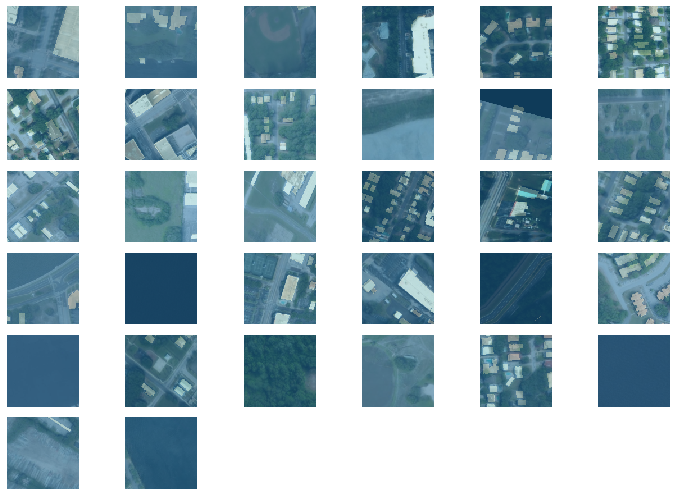

In [20]:

data.show_batch(8, figsize=(10,7))

In [25]:
# grab_idx??
 data.one_batch??

In [14]:
from ipywidgets import interact

In [ ]:
def browse_images(data, ds_type, rows, batch_num=0):
    n = len(digits.images)
    def view_batch(i):
        x,y = data.one_batch(ds_type, True, True)
        if reverse: x,y = x.flip(0),y.flip(0)
        n_items = rows **2 if self.train_ds.x._square_show else rows
        if self.dl(ds_type).batch_size < n_items: n_items = self.dl(ds_type).batch_size
        xs = [self.train_ds.x.reconstruct(grab_idx(x, i)) for i in range(n_items + data.batch_size * batch_num)]
        #TODO: get rid of has_arg if possible
        if has_arg(self.train_ds.y.reconstruct, 'x'):
            ys = [self.train_ds.y.reconstruct(grab_idx(y, i), x=x) for i,x in enumerate(xs)]
        else : ys = [self.train_ds.y.reconstruct(grab_idx(y, i)) for i in range(n_items)]
        self.train_ds.x.show_xys(xs, ys, **kwargs)
        
        plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Training: %s' % digits.target[i])
        plt.show()
    interact(view_image, i=(0,n-1))

In [94]:
class LossBinary:
    """
    Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCELoss()
#         self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        targets = targets.squeeze(1).float()
        outputs = outputs.argmax(dim=1).float()
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = torch.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss

In [36]:
def accuracy_pixel(input, target):
    target = target.squeeze(1)
    mask = target != 0
    return (input.argmax(dim=1)[mask] == target[mask]).float().mean()

def accuracy_jaccard(input, target):
    input=input.argmax(dim=1).float()
    target = target.squeeze(1).float()
    jaccard_target = (target == 1).float()
    intersection = (input * target).sum()
    union = input.sum() + target.sum()
    
    return intersection/union

In [33]:
wd =1e-2
metrics = [accuracy_pixel, accuracy_jaccard]
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)
# learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, loss_func=LossBinary(0.2))

In [126]:
learn.data.train_ds.x

SegmentationItemList (2160 items)
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
Path: /media/wwymak/Storage/urban-3D-satellite

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


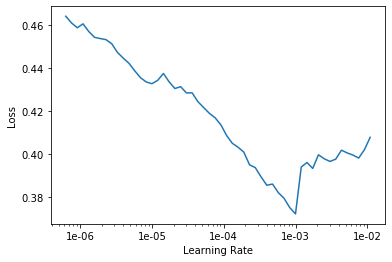

In [34]:

lr_find(learn)
learn.recorder.plot(skip_end=2)

In [35]:
lr=1e-3
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy_pixel,accuracy_jaccard,time
0,0.254142,0.196385,0.533669,0.300740,00:14
1,0.220260,0.167897,0.590947,0.327890,00:13
2,0.204733,0.159171,0.509057,0.316363,00:13
3,0.183314,0.149092,0.682177,0.355883,00:13
4,0.177200,0.148265,0.558928,0.337924,00:13
5,0.187327,0.174779,0.687430,0.337535,00:13
6,0.178002,0.132454,0.635264,0.360922,00:13
7,0.169620,0.126557,0.668879,0.370604,00:14
8,0.162531,0.127309,0.683323,0.371890,00:13
9,0.151202,0.120642,0.759419,0.385753,00:13


torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 

torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([2, 128, 128]) torch.Size([2, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 12

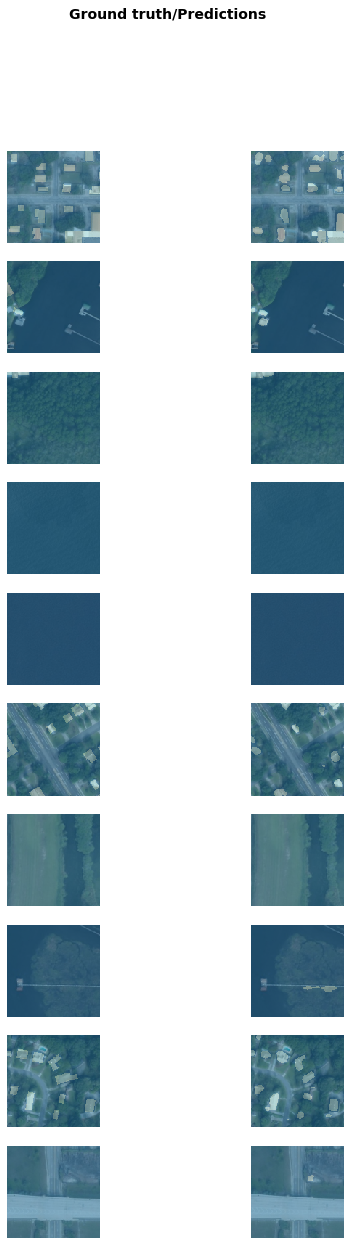

In [38]:
learn.show_results(rows=10, figsize=(8,20))

In [39]:
learn.save('stage1')

In [40]:
learn.summary()

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 64]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 64]         128        True      
______________________________________________________________________
ReLU                 [64, 64, 64]         0          False     
______________________________________________________________________
MaxPool2d            [64, 32, 32]         0          False     
______________________________________________________________________
Conv2d               [64, 32, 32]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 32, 32]         128        True      
______________________________________________________________________
ReLU                 [64, 32, 32]         0          False     
__________________________________________________

#### Diversion 
Let's try to figure out how to show image/mask/predictions that aren't alwasy the first batch

In [54]:
def one_batch_custom(datablock, batch_num=1, 
                     ds_type:DatasetType=DatasetType.Train, detach:bool=True, denorm:bool=True, cpu:bool=True)->Collection[Tensor]:
    "Get one batch from the data loader of `ds_type`. Optionally `detach` and `denorm`."
    dl = datablock.dl(ds_type)
    w = datablock.num_workers
    datablock.num_workers = 0
    iterator = iter(dl)
    [next(iterator) for i in range(batch_num-1)]
    try:     x,y = next(iterator)
    finally: datablock.num_workers = w
    if detach: x,y = to_detach(x,cpu=cpu),to_detach(y,cpu=cpu)
    norm = getattr(datablock,'norm',False)
    if denorm and norm:
        x = datablock.denorm(x)
        if norm.keywords.get('do_y',False): y = self.denorm(y, do_x=True)
    return x,y

In [55]:

def show_batch_custom(self, batch_num=1, rows:int=5, ds_type:DatasetType=DatasetType.Train, reverse:bool=False, **kwargs)->None:
    "Show a batch of data in `ds_type` on a few `rows`."
    x,y = one_batch_custom(self,batch_num, ds_type, True, True)
    if reverse: x,y = x.flip(0),y.flip(0)
    n_items = rows **2 if self.train_ds.x._square_show else rows
    if self.dl(ds_type).batch_size < n_items: n_items = self.dl(ds_type).batch_size
    xs = [self.train_ds.x.reconstruct(grab_idx(x, i)) for i in range(n_items)]
    #TODO: get rid of has_arg if possible
    if has_arg(self.train_ds.y.reconstruct, 'x'):
        ys = [self.train_ds.y.reconstruct(grab_idx(y, i), x=x) for i,x in enumerate(xs)]
    else : ys = [self.train_ds.y.reconstruct(grab_idx(y, i)) for i in range(n_items)]
    self.train_ds.x.show_xys(xs, ys, **kwargs)

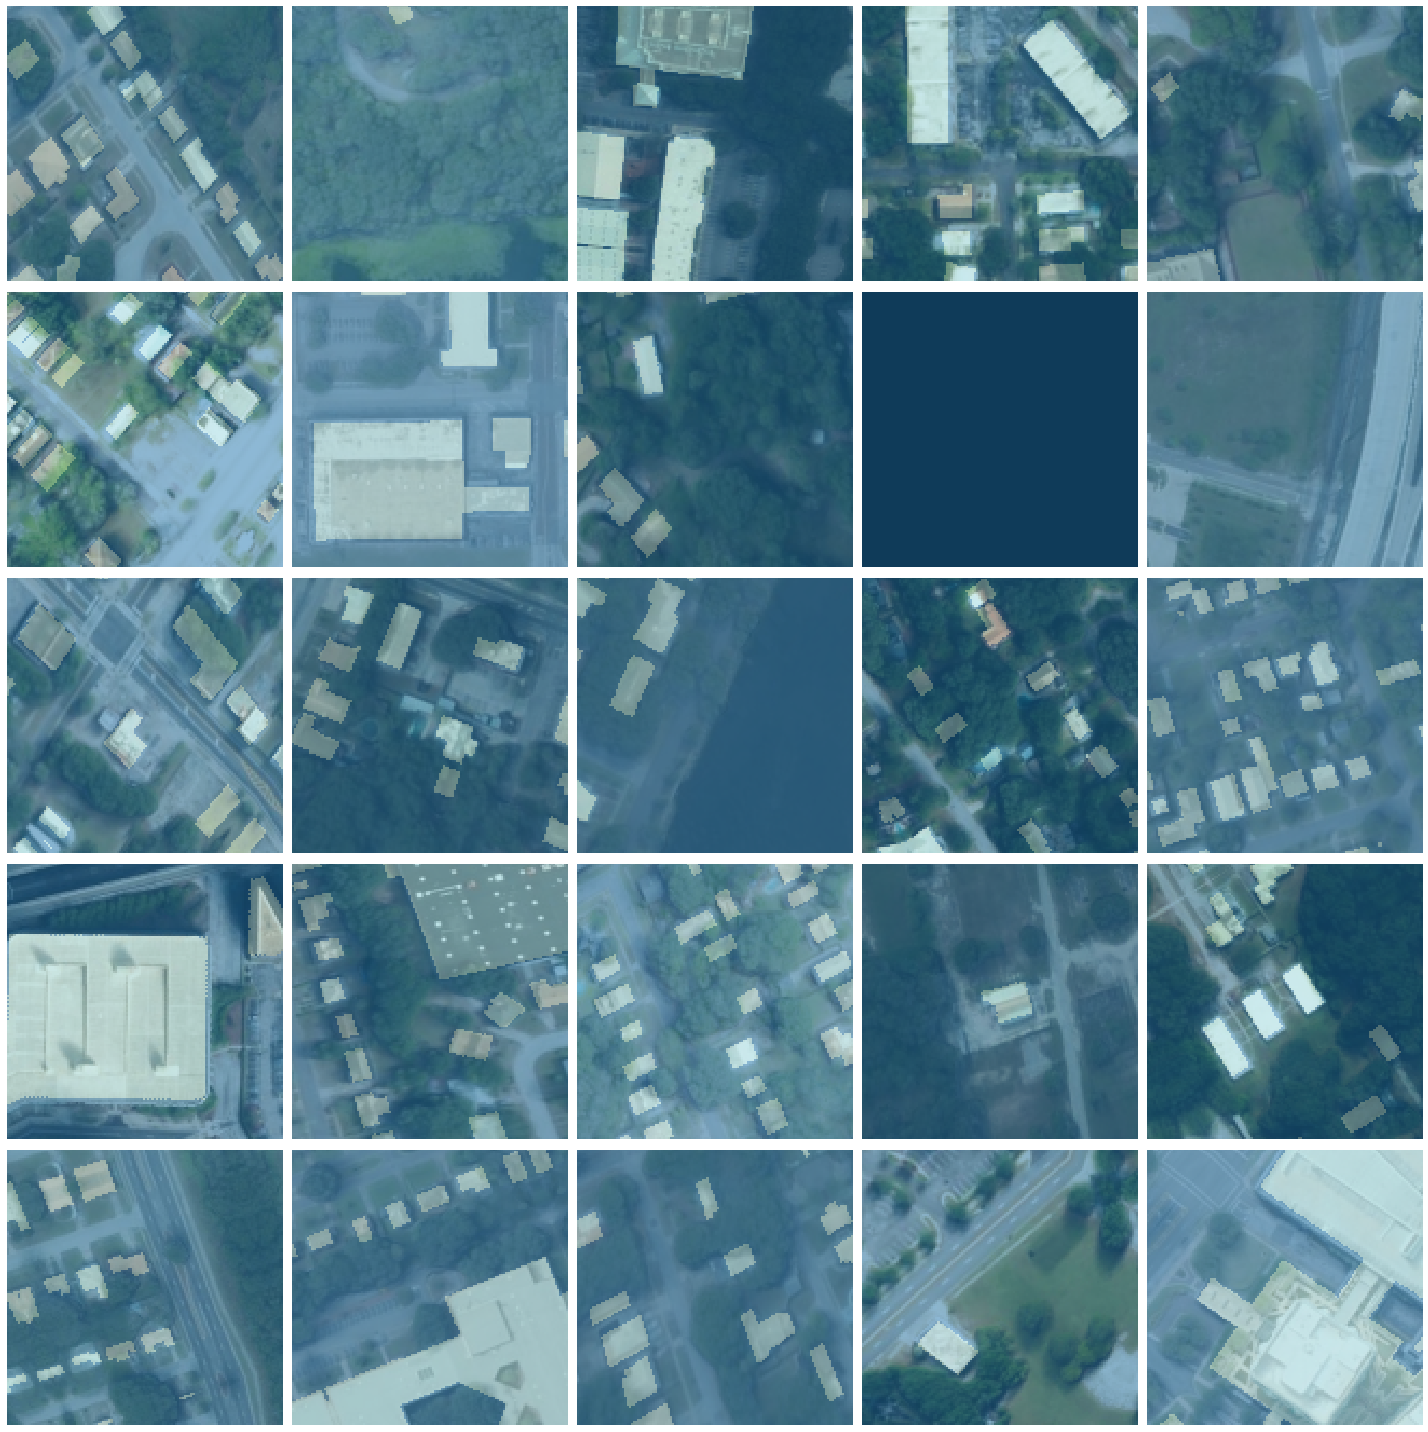

In [58]:
show_batch_custom(data, batch_num=15)

In [ ]:
def pred_batch(self, ds_type:DatasetType=DatasetType.Valid, batch:Tuple=None, reconstruct:bool=False, with_dropout:bool=False) -> List[Tensor]:
    "Return output of the model on one batch from `ds_type` dataset."
    if batch is not None: xb,yb = batch
    else: xb,yb = self.data.one_batch(ds_type, detach=False, denorm=False)
    cb_handler = CallbackHandler(self.callbacks)
    xb,yb = cb_handler.on_batch_begin(xb,yb, train=False)
    with torch.no_grad():
        if not with_dropout: preds = loss_batch(self.model.eval(), xb, yb, cb_handler=cb_handler)
        else: preds = loss_batch(self.model.eval().apply(self.apply_dropout), xb, yb, cb_handler=cb_handler)
        res = _loss_func2activ(self.loss_func)(preds[0])
    if not reconstruct: return res
    res = res.detach().cpu()
    ds = self.dl(ds_type).dataset
    norm = getattr(self.data, 'norm', False)
    if norm and norm.keywords.get('do_y',False):
        res = self.data.denorm(res, do_x=True)
    return [ds.reconstruct(o) for o in res]



def show_results(self, ds_type=DatasetType.Valid, rows:int=5, **kwargs):
    "Show `rows` result of predictions on `ds_type` dataset."
    #TODO: get read of has_arg x and split_kwargs_by_func if possible
    #TODO: simplify this and refactor with pred_batch(...reconstruct=True)
    n_items = rows ** 2 if self.data.train_ds.x._square_show_res else rows
    if self.dl(ds_type).batch_size < n_items: n_items = self.dl(ds_type).batch_size
    ds = self.dl(ds_type).dataset
    self.callbacks.append(RecordOnCPU())
    preds = self.pred_batch(ds_type)
    *self.callbacks,rec_cpu = self.callbacks
    x,y = rec_cpu.input,rec_cpu.target
    norm = getattr(self.data,'norm',False)
    if norm:
        x = self.data.denorm(x)
        if norm.keywords.get('do_y',False):
            y     = self.data.denorm(y, do_x=True)
            preds = self.data.denorm(preds, do_x=True)
    analyze_kwargs,kwargs = split_kwargs_by_func(kwargs, ds.y.analyze_pred)
    preds = [ds.y.analyze_pred(grab_idx(preds, i), **analyze_kwargs) for i in range(n_items)]
    xs = [ds.x.reconstruct(grab_idx(x, i)) for i in range(n_items)]
    if has_arg(ds.y.reconstruct, 'x'):
        ys = [ds.y.reconstruct(grab_idx(y, i), x=x) for i,x in enumerate(xs)]
        zs = [ds.y.reconstruct(z, x=x) for z,x in zip(preds,xs)]
    else :
        ys = [ds.y.reconstruct(grab_idx(y, i)) for i in range(n_items)]
        zs = [ds.y.reconstruct(z) for z in preds]
    ds.x.show_xyzs(xs, ys, zs, **kwargs)

#### Diversion 2 nvidia dali



#### Diversion 3 
object detection

#### back to some more training

In [60]:

learn.unfreeze()
lrs = slice(lr/400,lr/4)
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_pixel,accuracy_jaccard,time
0,0.137798,0.118765,0.742097,0.385279,00:14
1,0.138037,0.117479,0.739267,0.385646,00:14
2,0.137986,0.114829,0.727980,0.385752,00:14
3,0.135245,0.119745,0.761964,0.386985,00:14
4,0.134211,0.115979,0.762290,0.388885,00:14
5,0.135102,0.111726,0.714461,0.386070,00:14
6,0.133841,0.114469,0.670720,0.377589,00:13
7,0.133295,0.116886,0.718288,0.384777,00:13
8,0.129710,0.107987,0.746210,0.393113,00:13
9,0.128939,0.112272,0.769360,0.394093,00:13


torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 

torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([2, 128, 128]) torch.Size([2, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 128, 128]) torch.Size([32, 128, 128]) torch.float32 torch.float32
torch.Size([32, 12

Traceback (most recent call last):
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.6/shutil.py", line 484, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/wwymak/anaconda3/envs/solaris/lib/python3.6/shutil.py", line 482, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-z367rdw2'


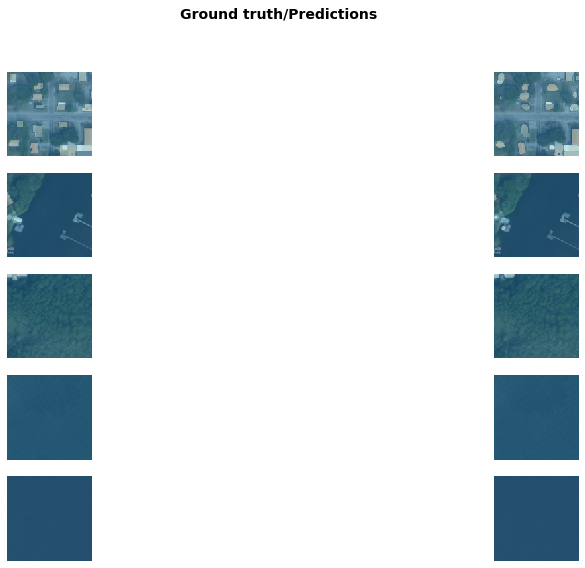

In [63]:
learn.show_results(ds_type=DatasetType.Valid, rows=5, figsize=(16,9))
# learn.data.one_batch??

In [64]:
learn.save('stage1')

In [43]:
size = 256
bs=8
wd = 1e-2
data = (src.transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

metrics = [accuracy_pixel, accuracy_jaccard]
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

learn.load('stage1')
learn.freeze()

In [44]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


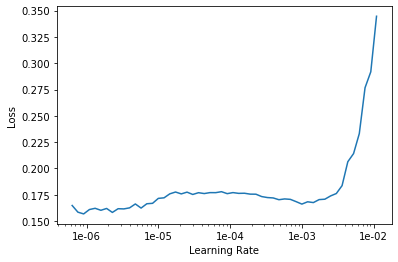

In [45]:
learn.recorder.plot(skip_end=1)

In [47]:
lr = 1e-4
lrs = slice(lr/100,lr)
learn.fit_one_cycle(10, lr, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_pixel,accuracy_jaccard,time
0,0.155156,0.129487,0.733756,0.375601,00:51
1,0.149309,0.121975,0.721925,0.378341,00:51
2,0.145833,0.117809,0.719442,0.380329,00:53
3,0.138027,0.113605,0.705134,0.381143,00:53
4,0.136485,0.109898,0.727271,0.387845,00:55
5,0.134978,0.113328,0.786020,0.391695,00:54
6,0.129202,0.108084,0.727464,0.389035,00:54
7,0.131066,0.114635,0.693209,0.381046,00:53
8,0.127092,0.108974,0.748676,0.391658,00:53
9,0.119057,0.106051,0.753597,0.393337,00:53


In [48]:
learn.save('stage2')

In [49]:
learn.to_fp16()
learn.fit_one_cycle(5, lr, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_pixel,accuracy_jaccard,time
0,0.116611,0.102933,0.758465,0.395954,00:51
1,0.118274,0.102889,0.763490,0.395337,00:46
2,0.120769,0.108468,0.691441,0.383952,00:45
3,0.119804,0.103435,0.753353,0.395253,00:46
4,0.115040,0.100149,0.771708,0.398484,00:46


In [50]:
learn.fit_one_cycle(5, lr, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_pixel,accuracy_jaccard,time
0,0.114880,0.100154,0.744976,0.395757,00:46
1,0.120912,0.101577,0.767035,0.397641,00:46
2,0.119724,0.103168,0.778629,0.398259,00:45
3,0.112687,0.103537,0.783995,0.398797,00:44
4,0.118085,0.101138,0.768185,0.398105,00:46


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


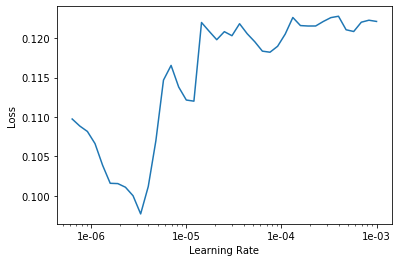

In [52]:
learn.save('stage2')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

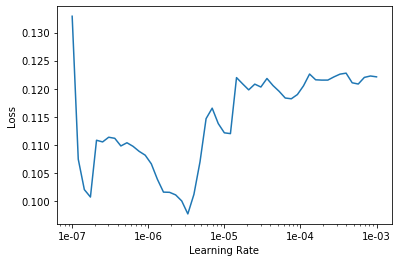

In [54]:
learn.recorder.plot(skip_start=0)

In [55]:
lr = 1e-6
lrs = slice(lr/100,lr)
learn.fit_one_cycle(10, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_pixel,accuracy_jaccard,time
0,0.113509,0.099938,0.769480,0.399045,00:48
1,0.113890,0.101489,0.771797,0.398242,00:48
2,0.109333,0.099850,0.776689,0.399899,00:47
3,0.113054,0.099762,0.770268,0.399119,00:47
4,0.113302,0.099490,0.774007,0.399510,00:48
5,0.109710,0.098436,0.766653,0.399763,00:50
6,0.107936,0.100005,0.770708,0.398836,00:49
7,0.111191,0.099971,0.763958,0.398405,00:48
8,0.114018,0.098482,0.774158,0.400685,00:48
9,0.109831,0.099282,0.774174,0.399934,00:49


In [56]:
learn.save('stage2')

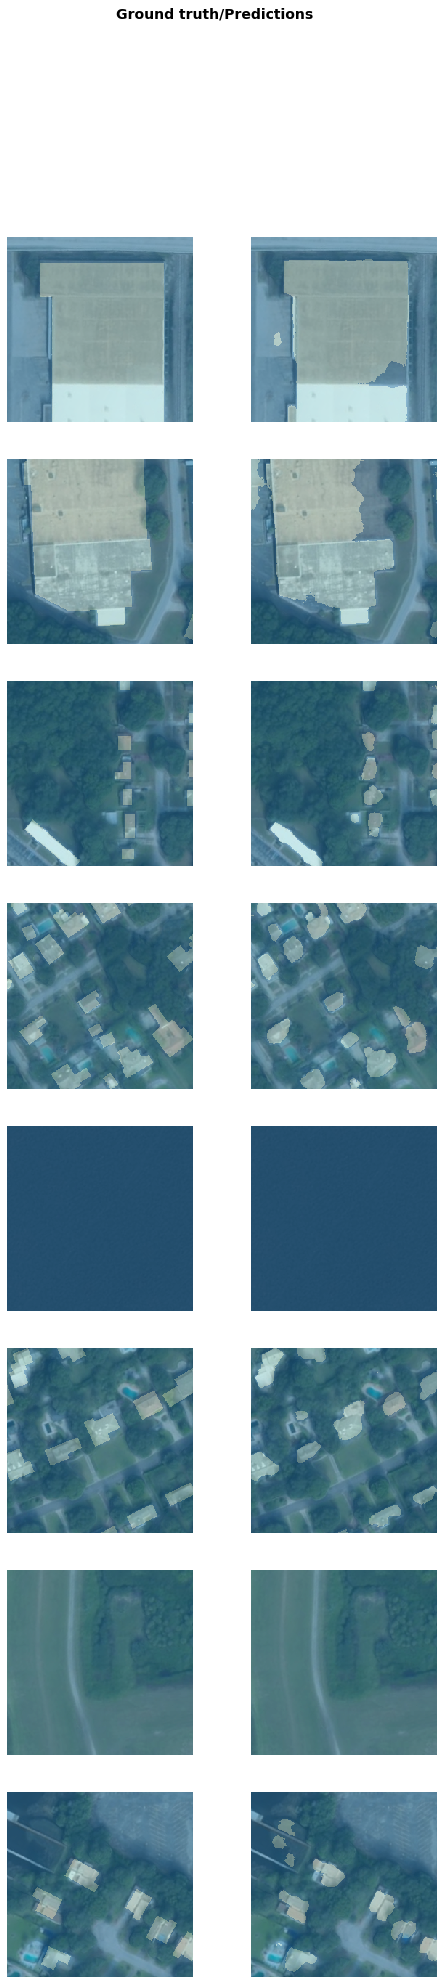

In [59]:
learn.show_results(ds_type=DatasetType.Valid, rows=15)

In [27]:
class NRandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

            
        
    def __init__(self, output_size, n=4, padding=0, pad_if_needed=False):
        self.output_size = output_size # size of crop
        self.padding = padding
        self.pad_if_needed = pad_if_needed
        self.n = n # number of crops
        
    def _get_crop(image, mask, w, h):
        new_h, new_w = self.output_size
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]
        
        mask = mask[top: top + new_h,
                      left: left + new_w]
        
        return image, mask


    def __call__(self, image, mask):
        assert image.shape[:2] == mask.shape[:2]

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        crops = [self._get_crop(image, mask, w, h) for i in range(self.n)]

        return tuple(crops)


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}
        return {'image': image, 'landmarks': landmarks}

Object `accimage` not found.


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
import utils
import numpy as np


class LossBinary:
    """
    Loss defined as \alpha BCE - (1 - \alpha) SoftJaccard
    """

    def __init__(self, jaccard_weight=0):
        self.nll_loss = nn.BCEWithLogitsLoss()
        self.jaccard_weight = jaccard_weight

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            jaccard_target = (targets == 1).float()
            jaccard_output = F.sigmoid(outputs)

            intersection = (jaccard_output * jaccard_target).sum()
            union = jaccard_output.sum() + jaccard_target.sum()

            loss -= self.jaccard_weight * torch.log((intersection + eps) / (union - intersection + eps))
        return loss


class LossMulti:
    def __init__(self, jaccard_weight=0, class_weights=None, num_classes=1):
        if class_weights is not None:
            nll_weight = utils.cuda(
                torch.from_numpy(class_weights.astype(np.float32)))
        else:
            nll_weight = None
        self.nll_loss = nn.NLLLoss2d(weight=nll_weight)
        self.jaccard_weight = jaccard_weight
        self.num_classes = num_classes

    def __call__(self, outputs, targets):
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)

        if self.jaccard_weight:
            eps = 1e-15
            for cls in range(self.num_classes):
                jaccard_target = (targets == cls).float()
                jaccard_output = outputs[:, cls].exp()
                intersection = (jaccard_output * jaccard_target).sum()

                union = jaccard_output.sum() + jaccard_target.sum()
                loss -= torch.log((intersection + eps) / (union - intersection + eps)) * self.jaccard_weight
        return loss

In [17]:
2048/256

8.0